In [2]:
 #Import Tensorflow
import tensorflow as tf
# Take Keras from tensorflow and import models and layers from keras
from tensorflow.keras import models, layers
#Import matplotlib
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

In [3]:
ISIZE = 256
BSIZE = 64
EPOCHS = 25
CHANNELS = 3

In [4]:
Idataset = tf.keras.preprocessing.image_dataset_from_directory(
'Dataset/Tomato',
 shuffle=True,
 image_size = (ISIZE,ISIZE),
 batch_size = BSIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
cnames = Idataset.class_names
cnames

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [51]:
len(Idataset)

251

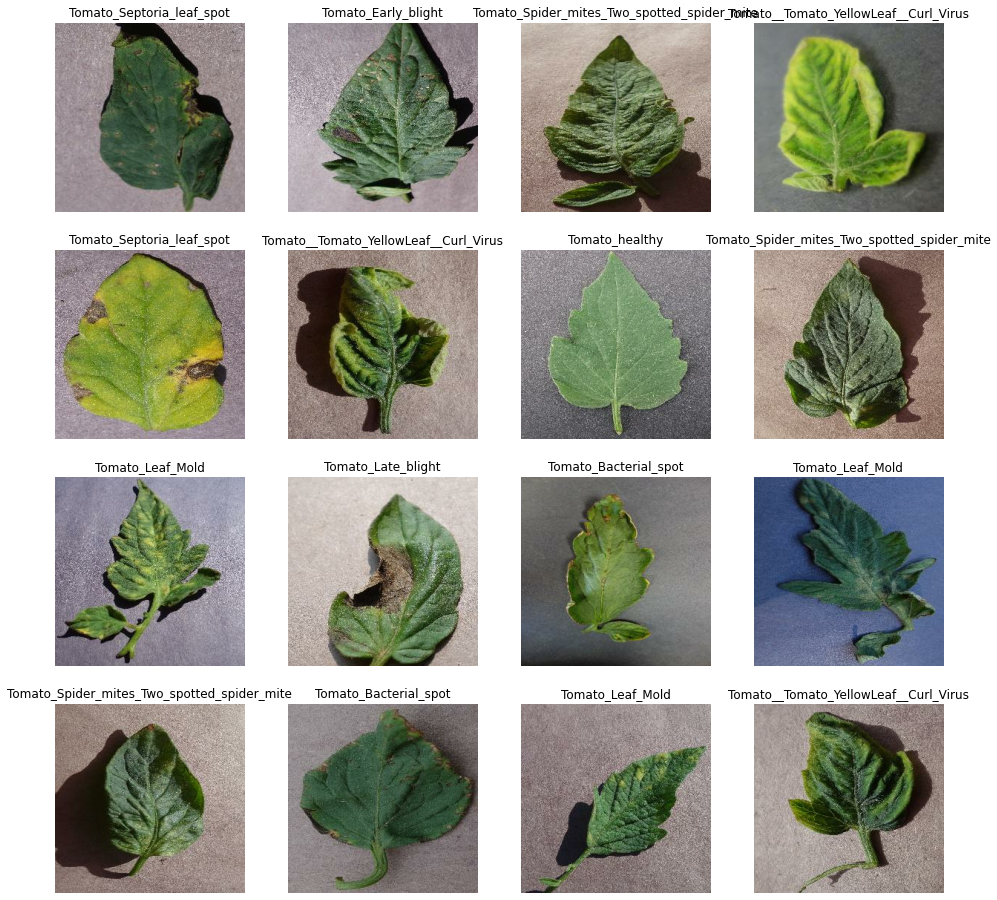

In [118]:
plt.figure(figsize=(16,16))
for batch_image,batch_label in Idataset.take(1):
    for i in range(16):
        pt = plt.subplot(4,4,i+1)
        plt.imshow(batch_image[i].numpy().astype('uint8'))
        plt.title(cnames[batch_label[i]])
        plt.axis('off')

In [52]:
#Split training , test and validation data
#80% data for training , 15% validation , 5% test
#function to perform partioning of data set
def partionining_of_IDataset(ds,train_split=0.8,val_split=0.05,test_split=0.15,shuffle = True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle_size:
        ds = ds.shuffle(shuffle_size,seed=7)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    test_size = int(ds_size*test_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)
    
    return train_ds,val_ds,test_ds

In [53]:
 #prepare training , test & validation data set
train_set,validation_set,testing_set = partionining_of_IDataset(Idataset,0.8,0.10,0.10)

In [54]:
tf.debugging.set_log_device_placement(True)
#cache images on CPU as GPU works on training to improve performance
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testing_set = testing_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [55]:
#Resizing Image ( Regularizing Images) And Scaling Images
resized_rescaled_images = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(ISIZE,ISIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [56]:
#Image Augmentation ( Recreate multiple format( transform, rotate, contrast) of same image to train model better)
augmented_images = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [97]:
#Start Building our model using CNN( Convolutional Neural Network)
#First we need to provide the resized and rescaled images layer, then pass the augmented images layer and then create the Convolutional layers
#In a CNN there are basically convolution layers & pooling set together in sequence ( there could be n layers) followed by dense layer
#Filter size of Conv2D = 32( through hyperparameter tuning), edges, activation = relu
n_classes = len(cnames)
image_size = (BSIZE,ISIZE,ISIZE,CHANNELS)
model = models.Sequential([
    resized_rescaled_images,
    augmented_images,
    layers.Conv2D(32,(5,5),activation='relu',input_shape = image_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=image_size)

In [98]:
#print the summary of the model to check total weights that needs to calculated in each layer
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (64, 252, 252, 32)        2432      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (64, 126, 126, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (64, 124, 124, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (64, 62, 62, 64)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (64, 60, 60, 64)        

In [99]:
tf.debugging.set_log_device_placement(True)
#Optimize the model using ADAM optimizer and sparse categorically loss function to intezer encode truth labels
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [101]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

#model Fitting 
history = model.fit(
train_set,
epochs = EPOCHS,
batch_size = BSIZE,
verbose = 1,
validation_data = validation_set
    )

Epoch 1/25
200/200 [==============================] - 399s 2s/step - loss: 0.4328 - accuracy: 0.8482 - val_loss: 0.4794 - val_accuracy: 0.8338
Epoch 2/25
200/200 [==============================] - 413s 2s/step - loss: 0.3659 - accuracy: 0.8709 - val_loss: 0.4011 - val_accuracy: 0.8600
Epoch 3/25
200/200 [==============================] - 430s 2s/step - loss: 0.3551 - accuracy: 0.8763 - val_loss: 0.3995 - val_accuracy: 0.8575
Epoch 4/25
200/200 [==============================] - 425s 2s/step - loss: 0.2863 - accuracy: 0.9033 - val_loss: 0.4992 - val_accuracy: 0.8350
Epoch 5/25
200/200 [==============================] - 437s 2s/step - loss: 0.3038 - accuracy: 0.8945 - val_loss: 0.4331 - val_accuracy: 0.8581
Epoch 6/25
200/200 [==============================] - 433s 2s/step - loss: 0.2503 - accuracy: 0.9152 - val_loss: 0.2800 - val_accuracy: 0.9031
Epoch 7/25
200/200 [==============================] - 434s 2s/step - loss: 0.2305 - accuracy: 0.9172 - val_loss: 0.3426 - val_accuracy: 0.8825

In [108]:
scores = model.evaluate(testing_set)

25/25 [==============================] - 9s 350ms/step - loss: 0.1751 - accuracy: 0.9469


In [109]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    predictions = model.predict(img_array)
    
    predicted_class = cnames[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])))
    return predicted_class, confidence

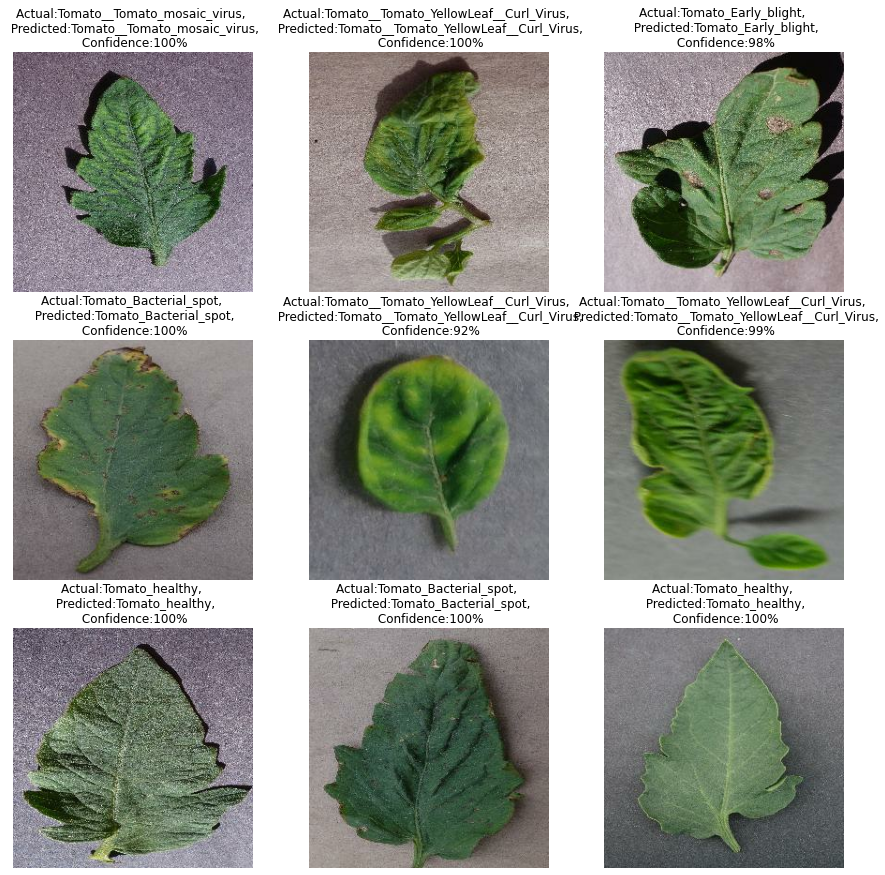

In [112]:
plt.figure(figsize=(15,15))
for images,labels in testing_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = cnames[labels[i]]
        plt.title(f"Actual:{actual_class}, \n Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')

In [111]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets
